# MMC Implementation

## Correct Implementation

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import warnings
import skmob
from tqdm import tqdm
import sys
sys.path.append('../')
from src.geo_utils import (get_clusters_from_tdf,
                            assign_tdf_points_to_clusters,
                            get_mmc_transitions,
                            get_stationary_vector)
import os

In [2]:
from src.geo_utils import (analyze_dates_with_events,
                           analyze_number_of_events, 
                           analyze_number_of_events_per_day, 
                           analyze_space_drift, 
                           analyze_speed_drift,
                           analyze_time_drift)

In [3]:
warnings.filterwarnings('ignore')

In [4]:
def get_distance(row):
    lat, lng, lat_last, lng_last = row['lat'], row['lng'], row['lat_last'], row['lng_last']
    return skmob.utils.utils.distance((lat, lng), (lat_last, lng_last))

### Evaluation of Implementation

In [ ]:
# Reading all the DataFrames and consolidating it into one
data_files = sorted([x for x in os.listdir('../data/') if 'geo_' in x])

data = pd.DataFrame()
for data_file in tqdm(data_files):
    data_i = pd.read_csv(f'../data/{data_file}')
    data = data.append(data_i)
data = data.reset_index(drop=True)

In [ ]:
# Homogenizing the dataset format

geo_columns = ['user', 'hour', 'lat', 'lng']

data['hour'] = data['date'] + ' ' + data['time']
data['hour'] = pd.to_datetime(data['hour'])
data['user'] = data['user_id'].map(int)

data = data[geo_columns]
data = data.drop_duplicates()
data = data.groupby(['user','hour'], as_index=False).nth(0)
data = data.reset_index(drop=True)


# Estimating distance and time differences

data[['lat_last','lng_last']] = data.groupby('user').shift(1)[['lat','lng']]
data['seconds_diff'] = data.groupby('user')['hour'].diff(1).dt.seconds

data['distance_to_last_km'] = data.apply(get_distance, axis=1) 
data['speed_mps'] = data['distance_to_last_km'] / data['seconds_diff'] * 1000

In [ ]:
data.info()

In [ ]:
del data['lat_last'], data['lng_last']

In [ ]:
data.head()

- El 99% de los registros están distanciados entre 0 y 5 segundos

#### Saving Data

In [ ]:
# Saving Data
data.to_parquet('../data/geolife_consolidated.parquet', index=False)

#### Loading Data (backup)

In [5]:
# Loading Data
data = pd.read_parquet('../data/geolife_consolidated.parquet')

In [6]:
data['date'] = data['hour'].dt.date

In [7]:
def analyze_time_drift(data):
    '''Analiza la distribución de la variación de tiempo (segundos) entre evento y evento'''
    
    # Distribución de número de eventos
    serie_seconds_events = data['seconds_diff'].value_counts()
    serie_seconds_events_log = np.log10(serie_seconds_events)

    print(serie_seconds_events)
    print()
    print(serie_seconds_events.quantile([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99, 1]))

    fig = plt.figure(figsize=(15,4))
    fig.add_subplot(1,2,1)
    data['seconds_diff'].hist(bins=100)
    plt.ylabel('Numero de Eventos')
    plt.xlabel('Delta de Segundos')
    
    fig.add_subplot(1,2,2)

    serie_seconds_events_log.hist(bins=30)
    plt.title('Distribución de eventos según drift en segundos (log10)');
    plt.ylabel('Numero de Eventos')
    plt.xlabel('Delta de Segundos (log10 scale)');
    

def analyze_space_drift(data):
    '''Analiza la distribución de la variación de distancia (Km) entre evento y evento'''

    serie_distance_events = data['distance_to_last_km'].value_counts()
    serie_distance_events_log = np.log10(serie_distance_events)
    
    print(serie_distance_events)
    print()
    print(serie_distance_events.quantile([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99, 1]))

    fig = plt.figure(figsize=(15,4))
    fig.add_subplot(1,2,1)
    data['distance_to_last_km'].hist(bins=100)
    plt.ylabel('Numero de Eventos')
    plt.xlabel('Delta de KM');
    
    fig.add_subplot(1,2,2)

    serie_distance_events_log.hist(bins=30)
    plt.title('Distribución de eventos según drift de distancia (log10)');
    plt.ylabel('Numero de Eventos')
    plt.xlabel('Delta de KM (log10 scale)');
    
    
def analyze_speed_drift(data):
    '''Analiza la velocidad (metros por segundo) de cada evento'''

    serie_speed = data['speed_mps']
    serie_speed_log = np.log10(serie_speed+1)
    
    print(serie_speed.quantile([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99, 1]))

    fig = plt.figure(figsize=(15,4))
    
    fig.add_subplot(1,2,1)
    serie_speed.hist(bins=100)
    plt.title('Distribución de eventos según velocidad');
    plt.ylabel('Numero de Eventos')
    plt.xlabel('Velocidad');
    
    fig.add_subplot(1,2,2)
    serie_speed_log.hist(bins=30)
    plt.title('Distribución de eventos según velocidad (log10)');
    plt.ylabel('Numero de Eventos')
    plt.xlabel('Velocidad (log10 scale)');
    
    
def analyze_number_of_events_per_day(data):
    '''Analiza la distribución de la variación de tiempo (segundos) entre evento y evento'''

    # Distribución de número de eventos
    df_events_per_day = data.groupby(['date','user'], as_index=False).size()
    
    serie_user_events_per_day = df_events_per_day['size']
    serie_user_events_per_day_log = np.log10(serie_user_events_per_day)

    print(serie_user_events_per_day)
    print()
    print(df_events_per_day['size'].quantile([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99, 1]))

    fig = plt.figure(figsize=(15,4))

    fig.add_subplot(1,2,1)
    serie_user_events_per_day.hist(bins=30)
    plt.title('Distribución de número de eventos por usuarios por día');
    plt.ylabel('Numero de Usuarios')
    plt.xlabel('Número de eventos en un día')    
    
    fig.add_subplot(1,2,2)
    serie_user_events_per_day_log.hist(bins=30)
    plt.title('Distribución de número de eventos por usuarios por día (log10)');
    plt.ylabel('Numero de Usuarios')
    plt.xlabel('Número de eventos en un día (log10 scale)')
    
def analyze_number_of_events(data):
    # Distribución de número de eventos
    serie_user_events = data['user'].value_counts()
    serie_user_events_log = np.log10(serie_user_events)

    print(serie_user_events)
    print()
    print(serie_user_events.quantile([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99, 1]))

    fig = plt.figure(figsize=(15,4))

    fig.add_subplot(1,2,1)
    serie_user_events.hist(bins=30)
    plt.title('Distribución de usuarios según Nro de Eventos');
    plt.ylabel('Numero de Usuarios')
    plt.xlabel('Número de eventos')    
    
    fig.add_subplot(1,2,2)
    serie_user_events_log.hist(bins=30)
    plt.title('Distribución de usuarios según Nro de Eventos (log10)');
    plt.ylabel('Numero de Usuarios')
    plt.xlabel('Número de eventos (log10 scale)')
    

def analyze_dates_with_events(data):
    # Distribución de número de eventos
    serie_user_events = data[['user','date']].drop_duplicates()['user'].value_counts()
    serie_user_events_log = np.log10(serie_user_events)

    print(serie_user_events)

    fig = plt.figure(figsize=(15,4))
    fig.add_subplot(1,2,1)
    serie_user_events.hist(bins=30)
    plt.title('Distribución de usuarios según Nro de Días con Eventos');
    plt.ylabel('Numero de Usuarios')
    plt.xlabel('Número de Días con eventos')
    
    fig.add_subplot(1,2,2)

    serie_user_events_log.hist(bins=30)
    plt.title('Distribución de usuarios según Nro de Días con Eventos (log10)');
    plt.ylabel('Numero de Usuarios')
    plt.xlabel('Número de eventos (log10 scale)')

153    2156964
128    1208309
41     1057038
17     1026176
163     969084
        ...   
171        177
87         152
178         84
72          81
60          17
Name: user, Length: 182, dtype: int64

0.10        718.90
0.20       2534.00
0.30       6851.40
0.40      14677.40
0.50      35181.50
0.60      55863.80
0.70      90573.50
0.80     175329.20
0.90     386695.30
0.95     608317.60
0.99    1085779.49
1.00    2156964.00
Name: user, dtype: float64


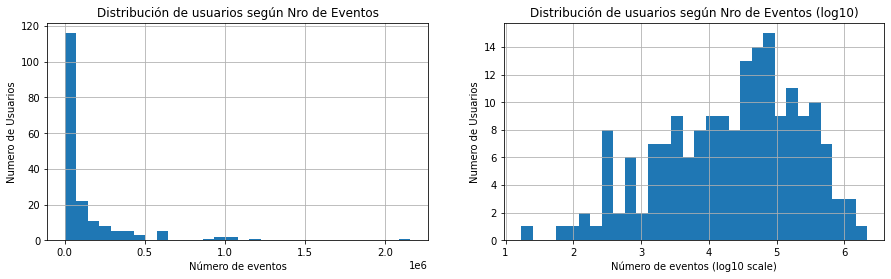

In [8]:
analyze_number_of_events(data)

0          3
1         28
2         58
3          9
4         55
        ... 
11142    730
11143    789
11144    871
11145    319
11146    296
Name: size, Length: 11147, dtype: int64

0.00        1.0
0.10      133.6
0.20      352.0
0.30      565.0
0.40      818.0
0.50     1168.0
0.60     1629.0
0.70     2306.0
0.80     3273.0
0.90     5099.4
0.95     7094.4
0.99    14375.0
1.00    59767.0
Name: size, dtype: float64


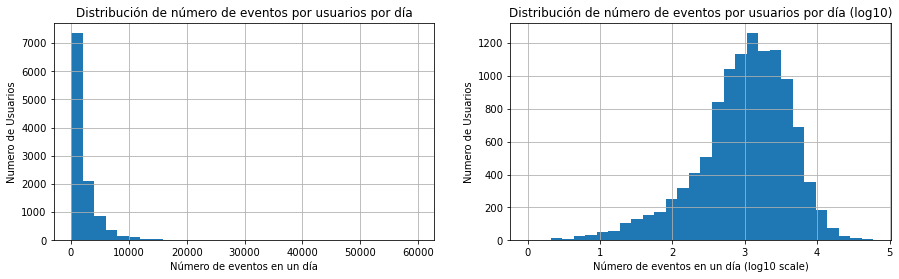

In [9]:
analyze_number_of_events_per_day(data)

153    1273
128     909
163     552
144     341
68      297
       ... 
49        1
143       1
151       1
178       1
149       1
Name: user, Length: 182, dtype: int64


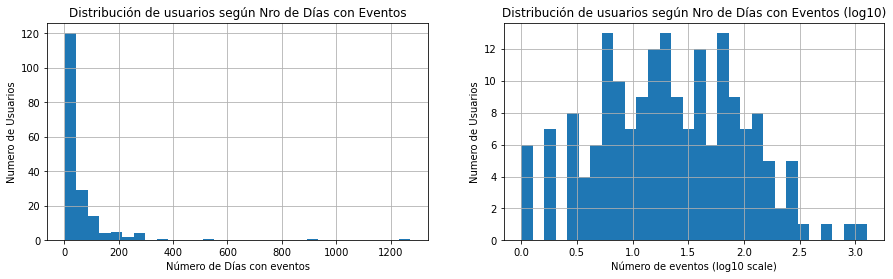

In [10]:
analyze_dates_with_events(data)

In [11]:
analyze_space_drift(data)

KeyError: 'distance_to_last_km'

In [12]:
analyze_space_drift(data)

KeyError: 'distance_to_last_km'

In [13]:
analyze_speed_drift(data)

KeyError: 'speed_mps'

#### Latitud y Longitud

<AxesSubplot:>

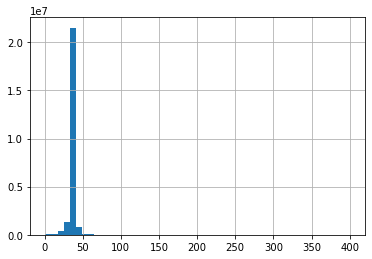

In [14]:
data['lat'].hist(bins=50)

<AxesSubplot:>

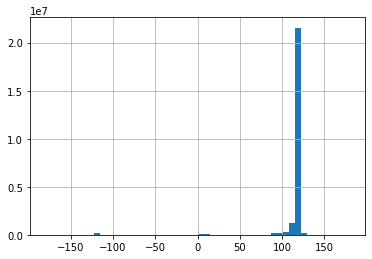

In [15]:
data['lng'].hist(bins=50)

In [16]:
data.shape

(24178078, 5)

- Datashader

In [17]:
dd = data.sample(20000)

In [18]:
import seaborn as sns

<AxesSubplot:xlabel='lng', ylabel='lat'>

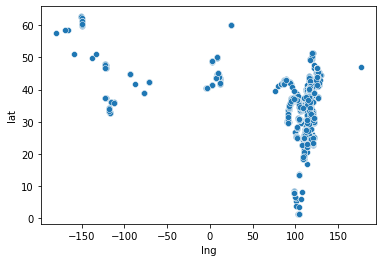

In [19]:
sns.scatterplot(data=dd, x='lng', y='lat')

<AxesSubplot:xlabel='lat', ylabel='lng'>

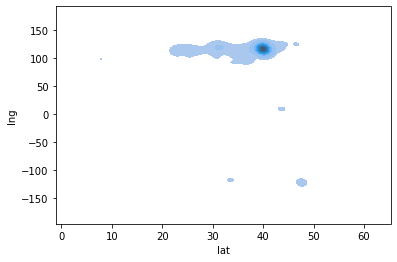

In [20]:
sns.kdeplot(data=dd, x='lat', y='lng', fill=True)

__Escenarios:__
- Base
- Filtro por país
- Filtro por tiempo en lugar

__Acuerdos__
- Quitar usuarios con menos de 1000 eventos
- Probar los 3 escenarios

In [21]:
def filter_min_events_per_user(_df, min_events, user_col = 'user'):
    print('Datos iniciales:')
    print('# Registros: {:,}'.format(_df.shape[0]), '\t|', '# Usuarios: {}'.format(_df[user_col].nunique()))
    print('-'*70)
    users_to_del = _df.groupby(user_col)[user_col].count()[_df.groupby(user_col)[user_col].count()<min_events].index
    _df = _df[~_df[user_col].isin(users_to_del)]
    
    print('Datos finales:')
    print('# Registros: {:,}'.format(_df.shape[0]), '\t|', '# Usuarios: {}'.format(_df[user_col].nunique()))
    print('-'*70)
    return _df 

In [22]:
data = filter_min_events_per_user(data, 1000)

Datos iniciales:
# Registros: 24,178,078 	| # Usuarios: 182
----------------------------------------------------------------------
Datos finales:
# Registros: 24,167,443 	| # Usuarios: 158
----------------------------------------------------------------------


In [23]:
def filter_min_days_per_user(_df, min_days, user_col = 'user', date_col  = 'date'):
    print('Datos iniciales:')
    print('# Registros: {:,}'.format(_df.shape[0]), '\t|', '# Usuarios: {}'.format(_df[user_col].nunique()))
    print('-'*70)
    users_to_del = _df.groupby(user_col)[date_col].nunique()[_df.groupby(user_col)[date_col].nunique()<min_days].index
    _df = _df[~_df[user_col].isin(users_to_del)]
    
    print('Datos finales:')
    print('# Registros: {:,}'.format(_df.shape[0]), '\t|', '# Usuarios: {}'.format(_df[user_col].nunique()))
    print('-'*70)
    return _df 

In [24]:
data = filter_min_days_per_user(data, 10)

Datos iniciales:
# Registros: 24,167,443 	| # Usuarios: 158
----------------------------------------------------------------------
Datos finales:
# Registros: 23,576,497 	| # Usuarios: 120
----------------------------------------------------------------------


0          3
1         28
2         58
3         55
4         30
        ... 
10820    730
10821    789
10822    871
10823    319
10824    296
Name: size, Length: 10825, dtype: int64

0.00        1.00
0.10      155.40
0.20      375.00
0.30      585.00
0.40      844.60
0.50     1196.00
0.60     1655.00
0.70     2325.00
0.80     3305.40
0.90     5108.40
0.95     7079.40
0.99    14280.08
1.00    59767.00
Name: size, dtype: float64


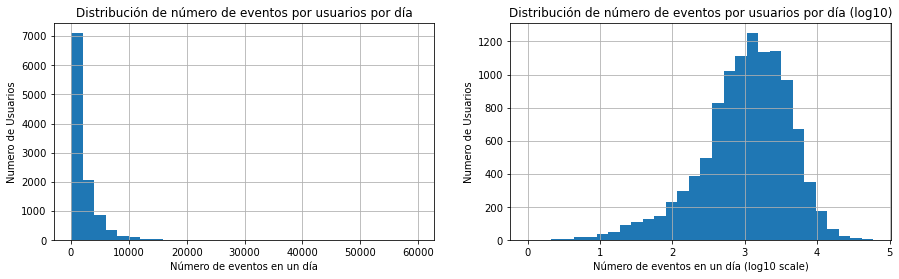

In [27]:
analyze_number_of_events_per_day(data)

In [29]:
from skmob.preprocessing import (filtering, 
                                 detection, 
                                 compression, 
                                 clustering)

In [34]:
# Creating a Trajectory DF to analyze the impact of filtering by velocity
trgeo = skmob.TrajDataFrame(
    data, 
    datetime='hour',
    user_id='user'
)

In [35]:
# 1. Noise Filtering
analyze_number_of_events_per_day(filtering.filter(trgeo, max_speed_kmh=0.1))

KeyboardInterrupt: 

In [ ]:
print('a')

In [ ]:
aux_dict = {}
aux_dict['user'] = []
aux_dict['number_points'] = []
aux_dict['min_tmstmp'] = []
aux_dict['max_tmstmp'] = []
for usr in data['user'].unique():
    aux_dict['user'].append(usr)
    aux_dict['number_points'].append(data[data['user']==usr].shape[0])
    aux_dict['min_tmstmp'].append(data[data['user']==usr]['hour'].min())
    aux_dict['max_tmstmp'].append(data[data['user']==usr]['hour'].max())
aux_dict = pd.DataFrame(aux_dict)
aux_dict['duracion'] = (aux_dict['max_tmstmp'] - aux_dict['min_tmstmp']).dt.total_seconds()/ 60
aux_dict.sort_values(by='duracion', ascending=True, inplace=True)
display(aux_dict)

In [ ]:
fig,ax = plt.subplots(figsize=(6,4))
ax.set_xscale('log')
plt.scatter(aux_dict['duracion'].values, aux_dict['number_points'].values, color='r')
plt.plot(aux_dict['duracion'].values, aux_dict['number_points'].values , color='r', linestyle='--')
"""
plt.axvline(60,0)
plt.text(60,0, 'H')
plt.axvline(60*24,0)
plt.text(60*24,0, 'D')
"""
plt.axvline(60*24*7,0)
plt.text(60*24*7,0, 'S')
plt.axvline(60*24*7*30,0)
plt.text(60*24*7*30,0, 'M')
ax.set_xlabel('Tiempo en minutos - log')
ax.set_ylabel('Cantidad de puntos')
#plt.axvline(60*24*7*30*365,0)
#plt.text(60*24*7*30*365,0, 'Y')
#plt.show()

In [ ]:
fig,ax = plt.subplots(figsize=(12,6))
#ax.set_xscale('log')
plt.scatter(aux_dict['duracion'].values, aux_dict['number_points'].values)
plt.plot(aux_dict['duracion'].values, aux_dict['number_points'].values )

#plt.show()

In [ ]:
data['seconds_diff'].nlargest(30)

-------|-----|-----------|---------|

--xxXx--|--xX-x--|--x--xX--|

In [ ]:
data['distance_to_last_km'].nlargest(30)